### Import packages

In [2]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Params

In [ ]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']
cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Analysis

In [ ]:
def info_value_woe(feature, target):
    ''' calculate information value and weight of evidence 
    read: https://www.slideshare.net/0xdata/feature-engineering-83511751
    notice that it's implemented as non-event/event; if opposite, woe changes sign
    '''
    nT = np.sum(target)
    nF = np.sum(~target)
    
    df = pd.concat([feature,target],axis=1)
    df.columns = ['feature','target']
    
    group = df.groupby('feature')['target']
    cal_woe = lambda y: np.log( ((np.sum(~y)+0.5)/nF) / ((np.sum(y)+0.5)/nT) )
    woe = group.agg(cal_woe).rename(columns={'target':'woe'})
    cal_diff = lambda y: np.sum(~y)/nF - np.sum(y)/nT
    diff_pct = group.agg(cal_diff).rename(columns={'target':'diff'})
    info_value = np.sum(woe * diff_pct)
    
    return woe, info_value

### Processing

In [ ]:
def pre_processing(df, cols_num, cols_cat, cols_feats):
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df['total_price'] = df['total_price'].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
     
    return df, cols_feats

In [ ]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)
    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)

        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [ ]:
def post_processing(y_pred, df):
    y_pred_final = pd.Series(y_pred.copy())
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].reset_index(drop=True)
        
    return y_pred_final.values

### Columns

In [ ]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [ ]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.head(5)

### Preprocessing

In [ ]:
df, cols_feats = pre_processing(df, cols_num, cols_cat, cols_feats)

### Construct feats cols

In [ ]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats_origin = cols_num + cols_cat

### Remove feats based on feature shuffle results (exp-l04-per-area)

In [ ]:
from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feat_imp = feat_imp[feat_imp['feats'] != 'none']

### Grid search

In [18]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01 }

lgb_other_params = {'num_boost_round': 20000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000 }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth': [16],
#                  'num_leaves': [300],
#                  'feature_fraction': [0.5],
#                  'min_data_in_leaf': [10],
#                  'lambda_l1': [0.01],
#                  'lambda_l2': [0.1],
#                 }

params_gsearch = {'max_depth': [-1, 16, 24],
                  'num_leaves': [300],           # may reduce in dim-reduction exp
                  'feature_fraction': [0.5],
                  'min_data_in_leaf': [10],
                  'lambda_l1': [0, 0.01, 0.1],
                  'lambda_l2': [0, 0.01, 0.1],
                  'n_feats_rm': [25, 50, 75, 100, 125, 150, 175]
                 }
N_fold = 3
N_iter = 189
score_low_bound = 5600 # if score smaller than this, skip the param set

#### Round 1

In [ ]:
# Round 1
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [ ]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats_origin, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        n_feats_rm = params_rand['n_feats_rm']
        params = params_fix.copy()
        params.update( params_rand )

        params_lgb = params.copy()
        del params_lgb['n_feats_rm']
        
        feats_rm = list(feat_imp.iloc[:n_feats_rm]['feats'].values)
        cols_feats = list(set(cols_feats_origin) - set(feats_rm))
        print('N feats (after):', len(cols_feats))

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()

        model = lgb.train(params_lgb, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(model.best_iteration)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

In [ ]:
print('Total computing time:', t1-t0)

In [ ]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

In [13]:
gsearch_results = []
with open('log-model-03', 'r') as ifile:
    for line in ifile:
        line = line.strip()
        line = line.replace(']', '],')
        line = line.replace(' ', ', ')
        line = line.replace(',,', ',')
        line = '[' + line + ']'
        gsearch_results.append(eval(line))

In [14]:
gsearch_results

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5753.869022347792,
  0.03947951308202,
  0.12606062674597365,
  0.009469859565460013,
  [5764.869135997275, 5748.870629152345, 5747.867301893753],
  [0.03841400633849459, 0.039980429005792815, 0.0400441039017726],
  [0.12560034373045953, 0.12604532305465926, 0.12653621345280222],
  [0.009442015471698841, 0.009453773843400992, 0.009513789381280207]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5753.202443287537,
  0.0395071365549

{75: 5753.869022347792, 100: 5753.202443287537, 50: 5753.202391619515, 25: 5751.869081832374, 150: 5751.535151544664, 125: 5736.202164753733, 175: 5709.533153966925}


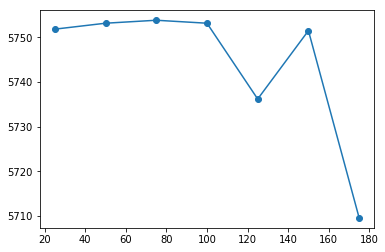

In [26]:
aaa= {}
for g in gsearch_results:
    nrm = g[0][11][1]
    score = g[1]
    if nrm not in aaa:
        aaa[nrm] = score
    elif score > aaa[nrm]:
            aaa[nrm] = score
print(aaa)
bbb = np.array(sorted(aaa.items(), key= lambda x: x[0]))
plt.plot(bbb[:,0], bbb[:,1], '-o')

In [15]:
metrics = ['score', 'mse', 'mae', 'mape']

In [20]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
#    result['best_iteration'] = np.mean([m.best_iteration for m in row[5]])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())] #+metrics+['best_iteration']]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,n_feats_rm
0,24,300,0.5,10,0.10,0.00,75
1,-1,300,0.5,10,0.01,0.10,100
2,-1,300,0.5,10,0.10,0.01,50
3,24,300,0.5,10,0.01,0.10,75
4,-1,300,0.5,10,0.00,0.01,25
5,24,300,0.5,10,0.10,0.00,50
6,24,300,0.5,10,0.10,0.10,50
7,16,300,0.5,10,0.10,0.10,150
8,24,300,0.5,10,0.10,0.01,75
9,16,300,0.5,10,0.00,0.01,75


In [21]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

KeyError: 'score'

In [ ]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

In [ ]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

In [ ]:
df_gsearch_results.columns

In [ ]:
# best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iteration':
        plt.scatter(df_gsearch_results['best_iteration'], df_gsearch_results[c])
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iteration'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best_iteration')
    plt.show()

### Feature importance

In [ ]:
lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

In [ ]:
lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()

### Compute correlation

#### correlation for num feats

In [ ]:
corr = pd.DataFrame({'corr': df[cols_num+['target']].corr()['target']})
corr['abs_corr'] = np.abs(corr['corr'])
corr = corr.sort_values(by='abs_corr')
print(corr.reset_index().values)
corr['cum_count'] = range(corr.shape[0], 0, -1)
plt.plot(corr['abs_corr'], corr['cum_count'], '-o')

#### info values for cat feats

In [ ]:
df['bin_target'] = ( df['target'] > np.median(df['target']) )

info_vals = []
for c in cols_cat:
    woe, iv = info_value_woe(df[c], df['bin_target'])
    info_vals.append( (c, iv) )
info_vals.sort(key = lambda x: x[1])
display(info_vals)

info_vals = [(c, iv, len(info_vals) - i) for i, (c, iv) in enumerate(info_vals)]
info_vals = pd.DataFrame(info_vals)
info_vals.columns = ['feats', 'iv', 'counts']
plt.xscale('log')
plt.plot(info_vals['iv'], info_vals['counts'], '-o')

# Results

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5753.869022347792,
  0.03947951308202,
  0.12606062674597365,
  0.009469859565460013,
  [5764.869135997275, 5748.870629152345, 5747.867301893753],
  [0.03841400633849459, 0.039980429005792815, 0.0400441039017726],
  [0.12560034373045953, 0.12604532305465926, 0.12653621345280222],
  [0.009442015471698841, 0.009453773843400992, 0.009513789381280207]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5753.202443287537,
  0.039507136554980594,
  0.12599606027360089,
  0.00946456486469243,
  [5770.869493115472, 5753.870582752263, 5734.867253994875],
  [0.03846211165831417, 0.039978342598186466, 0.04008095540844115],
  [0.125230607043014, 0.12610206201976779, 0.1266555117580209],
  [0.009412676391810737, 0.009457764417932593, 0.00952325378433396]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5753.202391619515,
  0.03943681600759935,
  0.12598104718987738,
  0.009463258056231353,
  [5749.86911153187, 5774.870779205181, 5734.867284121492],
  [0.03853937390571893, 0.039857376134319104, 0.03991369798276],
  [0.12559119676548472, 0.125863100109272, 0.1264888446948754],
  [0.00944091223467301, 0.00943924836977937, 0.009509613564241683]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5753.20230605263,
  0.03956406275813724,
  0.12608150560953504,
  0.009471944905229462,
  [5777.869162889716, 5740.870606992368, 5740.867148275806],
  [0.03851842833058906, 0.0400350894860593, 0.040138670457763356],
  [0.1255898777206347, 0.12606705471252022, 0.12658758439545023],
  [0.009441421374372155, 0.009455778395222623, 0.009518634946093604]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5751.869081832374,
  0.03948273885472799,
  0.12602331245362466,
  0.009466714082202532,
  [5755.869540456651, 5760.870519785739, 5738.867185254734],
  [0.03831925594103244, 0.040093275189239316, 0.040035685433912206],
  [0.12522630602593182, 0.12607541114055032, 0.1267682201943919],
  [0.009413451965821834, 0.009455765662129257, 0.009530924618656506]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5751.868893362126,
  0.03951027292835887,
  0.12610732078703193,
  0.009473010332742317,
  [5758.869063338008, 5773.870440429546, 5722.867176318821],
  [0.038527999748031484, 0.04002234797316286, 0.03998047106388224],
  [0.1255612228310466, 0.12614325839766447, 0.12661748113238477],
  [0.009438813058391756, 0.009460824373072576, 0.009519393566762617]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5751.53575403136,
  0.0394488368788101,
  0.12600088735629902,
  0.00946397273120988,
  [5764.869292637707, 5748.870587218214, 5740.867382238158],
  [0.03837398337568929, 0.04005572480660774, 0.03991680245413329],
  [0.12542362054669606, 0.1260761138983883, 0.12650292762381277],
  [0.009427799204546086, 0.0094545350895574, 0.009509583899526155]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5751.535151544664,
  0.039642158768187406,
  0.1263999239335986,
  0.009495682919677615,
  [5762.868823179015, 5736.869751424829, 5754.866880030148],
  [0.03857024112063313, 0.040386961060237585, 0.039969274123691494],
  [0.1257866152667855, 0.12678583845878255, 0.1266273180752278],
  [0.009455579269722014, 0.009508976644918324, 0.009522492844392508]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5751.202274026527,
  0.03951059301574985,
  0.1260924236622651,
  0.009472935734821398,
  [5760.869108103025, 5743.870581492748, 5748.86713248381],
  [0.03842048468642275, 0.04004670587863782, 0.040064588482188974],
  [0.12559086619972262, 0.12605348300342262, 0.1266329217836501],
  [0.009442738968965948, 0.009454512391038564, 0.009521555844459682]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5750.869004414458,
  0.03957692383376678,
  0.12612002818809476,
  0.009474272237328175,
  [5760.869296522382, 5748.870643505594, 5742.867073215397],
  [0.038460124184024655, 0.04008421263040513, 0.04018643468687054],
  [0.12549949886581344, 0.1260487150740168, 0.12681187062445404],
  [0.009434618959620502, 0.009454066722946323, 0.009534131029417697]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5749.869176991005,
  0.039463840215595646,
  0.1258704416075245,
  0.009454459552627838,
  [5745.869446152027, 5772.870846008391, 5730.867238812594],
  [0.038353738069290946, 0.03996248325894752, 0.04007529931854846],
  [0.12527674926772925, 0.12582108525376384, 0.1265134903010804],
  [0.00941669337262466, 0.009435339537530556, 0.009511345747728299]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5749.868996998136,
  0.03956298885959874,
  0.12607078282356335,
  0.009470786966902733,
  [5770.869435689308, 5739.870356133999, 5738.867199171102],
  [0.03843913140094592, 0.04016493828801014, 0.04008489688984015],
  [0.12528632697693864, 0.12622833388912705, 0.12669768760462435],
  [0.009417344692257034, 0.009468293925632254, 0.009526722282818914]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5749.202361109196,
  0.03950969457616503,
  0.1260480448808202,
  0.009468972104225808,
  [5761.869364571608, 5750.870504055989, 5734.867214699991],
  [0.03831858923212821, 0.040158015395236536, 0.04005247910113034],
  [0.12534697045504659, 0.1261591738855774, 0.12663799030183653],
  [0.009422853213608945, 0.009462311573872052, 0.009521751525196426]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5748.869072149585,
  0.039487409985805015,
  0.12602580984962308,
  0.00946750737081488,
  [5772.869440625416, 5736.870402972087, 5736.867372851252],
  [0.03838061690936287, 0.04011776441567246, 0.03996384863237971],
  [0.12526058939279652, 0.12619208693932046, 0.1266247532167523],
  [0.009416610988070288, 0.009465245305611514, 0.009520665818762836]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5748.869053830861,
  0.03950842541558149,
  0.12598873986931539,
  0.009463629963107007,
  [5750.869240882312, 5756.870641882529, 5738.867278727745],
  [0.03850222262027878, 0.0400611137362557, 0.039961939890209984],
  [0.12545921725497056, 0.12601307984911622, 0.12649392250385932],
  [0.009430836397722376, 0.009449434475032966, 0.00951061901656568]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5748.202501134959,
  0.03946832112334197,
  0.12597912507406014,
  0.009464234027356444,
  [5742.869417907698, 5760.870751287774, 5740.8673342094025],
  [0.038337513505959625, 0.03996593545281853, 0.04010151441124774],
  [0.12529402473691914, 0.12598066878862843, 0.1266626816966329],
  [0.00941853261149451, 0.00944912302839623, 0.009525046442178586]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5748.2023266877295,
  0.03943004379015196,
  0.12605848751565385,
  0.0094685468737908,
  [5752.869190488953, 5762.870615375545, 5728.867174198689],
  [0.03841684978241311, 0.03987532795060337, 0.0399979536374394],
  [0.1254641481111428, 0.12603574224543362, 0.12667557219038517],
  [0.00943032639505514, 0.009451472598737043, 0.009523841627580217]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5747.868934189038,
  0.03957070290714735,
  0.126140365370929,
  0.00947620258532847,
  [5742.869092271391, 5757.870603813885, 5742.867106481835],
  [0.038545381491991784, 0.04005796708055278, 0.040108760148897485],
  [0.12565614605881933, 0.12603191021160123, 0.12673303984236636],
  [0.009447293423508796, 0.009452631675907316, 0.009528682656569296]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5747.535737178038,
  0.03952142481621102,
  0.1260117057566894,
  0.00946675158025521,
  [5764.869566530414, 5748.870423006503, 5728.867221997198],
  [0.03837929678050264, 0.04008110841628673, 0.040103869251843706],
  [0.12514571602007454, 0.12623727761645215, 0.12665212363354147],
  [0.009407957321279553, 0.009469632260941427, 0.009522665158544651]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5747.535686603677,
  0.03953801631694413,
  0.12609479730186415,
  0.009472158398773356,
  [5758.8691078204365, 5750.870697028195, 5732.867254962397],
  [0.03849563014721213, 0.040028630694940726, 0.04008978810867954],
  [0.12566129649423102, 0.12598929853479293, 0.12663379687656845],
  [0.00944666443034632, 0.009448699640972587, 0.00952111112500116]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5747.2017379839135,
  0.03975724977846825,
  0.1264662578615238,
  0.009500875626520059,
  [5775.868982876322, 5734.869778396825, 5730.866452678596],
  [0.038617840237333466, 0.040464038921190194, 0.040189870176881096],
  [0.1256765282788144, 0.12675583190433184, 0.1269664134014252],
  [0.009446829004992772, 0.009507448073263607, 0.009548349801303795]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5746.869049075682,
  0.03951741348475866,
  0.1260467975924077,
  0.009468938601257642,
  [5758.8692224665, 5766.870736170194, 5714.867188590351],
  [0.0384723820080951, 0.04000687002859901, 0.04007298841758187],
  [0.12554463540923538, 0.12593503952609542, 0.12666071784189226],
  [0.009437889091499077, 0.00944497583706289, 0.009523950875210956]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5746.869012372018,
  0.0394973254071038,
  0.12607516414921974,
  0.009471003835272097,
  [5746.869203436753, 5744.870708271495, 5748.867125407804],
  [0.038386001383180254, 0.040013333583343455, 0.04009264125478771],
  [0.12555679182313717, 0.12596195565480825, 0.1267067449697138],
  [0.009439228158939512, 0.009448030630327394, 0.009525752716549384]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5746.535661933233,
  0.039538732937544126,
  0.12608619502498242,
  0.00947196404824596,
  [5747.86920247508, 5762.870741941964, 5728.867041382654],
  [0.03848531846243561, 0.03990400754945543, 0.040226872800741345],
  [0.12557692574868654, 0.12589583049800007, 0.12678582882826062],
  [0.009439603408782816, 0.009443288821278123, 0.009532999914676937]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5746.20237575701,
  0.039557902836591975,
  0.12598543254980918,
  0.00946299565335619,
  [5756.8692894772485, 5760.870822251386, 5720.867015542394],
  [0.038487851889310844, 0.040037297309939525, 0.04014855931052557],
  [0.12540209223605064, 0.12588428766625617, 0.12666991774712066],
  [0.009426500328882205, 0.009439081715253575, 0.009523404915932789]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5746.202344437998,
  0.03954063750788189,
  0.12606508199983088,
  0.009470059494663183,
  [5774.869546494487, 5751.870438324514, 5711.867048494996],
  [0.038365252891073766, 0.04011755583161176, 0.040139103800960155],
  [0.1252023776696313, 0.126254976641518, 0.12673789168834332],
  [0.009411519645211067, 0.009469230859353738, 0.009529427979424744]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5745.869039707951,
  0.039499442591785866,
  0.12599620927449343,
  0.009464362361748392,
  [5763.86912819329, 5766.870744713199, 5706.8672462173645],
  [0.038468640601464606, 0.03995359806663588, 0.04007608910725711],
  [0.12553519141094407, 0.12589137993872054, 0.12656205647381566],
  [0.009436683283279382, 0.009440998496859296, 0.009515405305106498]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5745.8690367387135,
  0.03947421635094178,
  0.12601248167287304,
  0.009466382239016946,
  [5764.869321680393, 5746.870530760639, 5725.86725777511],
  [0.03840478956603443, 0.04000792782817525, 0.040009931658615654],
  [0.12530972722608977, 0.12611558878283372, 0.12661212900969562],
  [0.009419230641987185, 0.009459354418351064, 0.009520561656712589]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5745.5357991915125,
  0.03951580851889619,
  0.12597611175944642,
  0.009463892517328988,
  [5733.869451093864, 5754.870533349812, 5747.867413130861],
  [0.03838703340766879, 0.04010146305378094, 0.04005892909523883],
  [0.12524822227176566, 0.12614194178493596, 0.12653817122163763],
  [0.009414994707899086, 0.009461912291228655, 0.009514770552859228]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5745.535785634922,
  0.0393675822670925,
  0.12593204819712087,
  0.00945915781129789,
  [5751.869275709539, 5739.870774041939, 5744.86730715329],
  [0.038356794558495215, 0.03979720319897691, 0.03994874904380539],
  [0.12539207956971213, 0.1259081215001288, 0.12649594352152163],
  [0.009425422607122362, 0.009441645094375369, 0.009510405732395939]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5745.535675540134,
  0.039551348027782214,
  0.1260870983324655,
  0.009471655249372619,
  [5756.869496140398, 5746.870615665073, 5732.866914814932],
  [0.03839458461673978, 0.04007912454614329, 0.04018033492046358],
  [0.1253460675402358, 0.12602453522325283, 0.12689069223390786],
  [0.009422445945429021, 0.009451875500772722, 0.009540644301916115]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5745.202445638045,
  0.03950072228115,
  0.12596366299819425,
  0.009462312211518768,
  [5757.86947901121, 5756.870622751129, 5720.867235151794],
  [0.038444554673033315, 0.04002744772186338, 0.0400301644485533],
  [0.12520736213873748, 0.12602271588370634, 0.12666091097213897],
  [0.009411418307995014, 0.00945193425543506, 0.009523584071126233]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5744.869033948523,
  0.03950711032283743,
  0.1260547630589115,
  0.009469652361478927,
  [5748.869307468893, 5762.870603225065, 5722.867191151611],
  [0.03837650272301265, 0.040041410625566466, 0.04010341761993317],
  [0.1254227486483263, 0.12605524781540225, 0.12668629271300588],
  [0.009428336052757145, 0.00945506248720659, 0.009525558544473046]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5744.535704243382,
  0.03953173736681287,
  0.12606397063943262,
  0.009470558160221557,
  [5759.869332868226, 5752.870520174217, 5720.867259687701],
  [0.03838967855211479, 0.04014043726421006, 0.04006509628411376],
  [0.12539524309572508, 0.1261424035783669, 0.12665426524420592],
  [0.009425831990312855, 0.009462242013621266, 0.009523600476730548]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5744.535642148795,
  0.03954182449285309,
  0.12601796892459677,
  0.009466051026708437,
  [5747.869117043543, 5760.870752384018, 5724.8670570188215],
  [0.038527348424676644, 0.03999320459737533, 0.04010492045650729],
  [0.12555731779783258, 0.12588432812313358, 0.12661226085282412],
  [0.009438454452473264, 0.009439957883815023, 0.009519740743837025]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5744.53559951256,
  0.039487108971663264,
  0.12612937362532092,
  0.009475569659925189,
  [5747.869110125351, 5737.870480698589, 5747.867207713738],
  [0.038430569815631636, 0.04000356935060351, 0.040027187748754633],
  [0.1255806470372047, 0.12618203785594395, 0.1266254359828141],
  [0.009440788586760231, 0.009464709498707381, 0.009521210894307956]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5744.202331327716,
  0.03949669752091309,
  0.1261137628737826,
  0.00947415993718706,
  [5749.869278362018, 5744.870408345921, 5737.867307275209],
  [0.038381480909464576, 0.04009808755121194, 0.04001052410206273],
  [0.12539106723317517, 0.1262639669883238, 0.1266862543998488],
  [0.009426256414419937, 0.009470193729965133, 0.009526029667176113]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5743.8690696645,
  0.039514046436135555,
  0.12599067999354052,
  0.009463700441418641,
  [5740.869132432472, 5759.870804922643, 5730.8672716383835],
  [0.03856470029928226, 0.03991582989763416, 0.040061609111490246],
  [0.1255826569470611, 0.12585274754732753, 0.12653663548623298],
  [0.009439010121315204, 0.009438712342003185, 0.009513378860937534]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5743.869008486911,
  0.039556680815793756,
  0.1260830882685978,
  0.0094716200483603,
  [5756.869340803531, 5748.870562686605, 5725.867121970596],
  [0.03848027920570751, 0.040052454918993126, 0.040137308322680636],
  [0.12538867369728918, 0.12609290456357194, 0.1267676865449322],
  [0.009425117150219268, 0.009457757967104598, 0.009531985027757034]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5743.535761055631,
  0.039490742318074125,
  0.12594499997312242,
  0.009460264031799547,
  [5736.869141765879, 5756.870868038562, 5736.867273362453],
  [0.038537678400363436, 0.03991047737336554, 0.0400240711804934],
  [0.12555249845402797, 0.12581153621896052, 0.12647096524637874],
  [0.009437925126297335, 0.009434663865384918, 0.009508203103716391]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5743.53567711989,
  0.03957329976168969,
  0.12602262779872767,
  0.009466380090303404,
  [5752.869289443765, 5760.870640516136, 5716.86710139977],
  [0.03854039652947896, 0.04011027826685023, 0.04006922448873989],
  [0.1254550476597843, 0.12598047499726875, 0.12663236073912995],
  [0.00943005433067627, 0.00944812261406857, 0.00952096332616537]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5743.535274252129,
  0.039639768311298694,
  0.12629778768586403,
  0.009488368640693579,
  [5753.869017465475, 5731.869857917696, 5744.866947373217],
  [0.03855124709381419, 0.04039249075792693, 0.039975567082154946],
  [0.12571666779043306, 0.1266767927785285, 0.12649990248863052],
  [0.009449214198529256, 0.009501589390399858, 0.009514302333151621]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5742.869018880495,
  0.039449303104376436,
  0.12606481328068186,
  0.009470404309202825,
  [5750.869198765037, 5738.870309746594, 5738.867548129855],
  [0.03837604924774008, 0.040074682351571224, 0.03989717771381801],
  [0.12546639704229634, 0.12632411771571056, 0.12640392508403872],
  [0.009431224919915278, 0.009476190671911855, 0.009503797335781343]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5742.868996016277,
  0.0394989248739509,
  0.12601204656789713,
  0.009465263548093862,
  [5745.869159436737, 5756.8706903917555, 5725.867138220339],
  [0.038494261812896696, 0.0399953300844664, 0.0400071827244896],
  [0.1254839270095041, 0.12596682123228575, 0.12658539146190165],
  [0.00943266287891228, 0.009446117601861282, 0.00951701016350802]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5742.5356085957865,
  0.03958266970699873,
  0.1261348759593408,
  0.009475121544936127,
  [5734.869112060917, 5752.870722461719, 5739.866991264723],
  [0.03857273303809209, 0.039984895491774614, 0.0401903805911295],
  [0.1256896092066467, 0.12591559285441084, 0.12679942581696493],
  [0.00944848173686452, 0.009443329382121517, 0.009533553515822345]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5742.202336701786,
  0.03949750173534399,
  0.12605235599458955,
  0.009469399096628727,
  [5754.869440750606, 5738.870445611689, 5732.8671237430635],
  [0.03833851888854108, 0.040063182244000524, 0.04009080407349036],
  [0.12523221219897068, 0.12619173812097073, 0.12673311766382725],
  [0.00941332197559881, 0.00946541304806508, 0.009529462266222288]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5742.201950678459,
  0.03969685710054779,
  0.12632237146823969,
  0.009490321245196174,
  [5747.869189496251, 5751.869910360502, 5726.866752178624],
  [0.03850612810320729, 0.04046002271588445, 0.040124420482551625],
  [0.12554789258902893, 0.12666776808264027, 0.1267514537330498],
  [0.009437126759981292, 0.00950140834184357, 0.009532428633763662]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5742.201703438928,
  0.03966953430209447,
  0.12652835896909947,
  0.009505699729224219,
  [5758.868913095632, 5722.869465056548, 5744.866732164605],
  [0.038524977044451424, 0.040504489027491306, 0.039979136834340685],
  [0.12575805931071557, 0.12703825647685943, 0.12678876111972343],
  [0.009453155732462417, 0.009528651126588449, 0.00953529232862179]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5741.869005018035,
  0.03947014678327385,
  0.12608722283077414,
  0.009472298123290155,
  [5749.8692679438145, 5741.8703029150565, 5733.8674441952335],
  [0.03836993978266907, 0.04002520310019659, 0.0400152974669559],
  [0.12543128072881765, 0.12633329811070376, 0.12649708965280104],
  [0.00942881502508501, 0.009476120381782268, 0.009511958963003182]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5741.5357743768445,
  0.03942514036332185,
  0.12596765031209942,
  0.009463181940911588,
  [5740.869412359245, 5748.870660833039, 5734.867249938248],
  [0.0383205757767113, 0.03991076192870582, 0.040044083384548415],
  [0.12530081431214235, 0.1259639989679606, 0.12663813765619525],
  [0.009418476924607096, 0.009448507502910769, 0.009522561395216896]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5741.535740096002,
  0.039456148426836375,
  0.12599508216921743,
  0.009464994341357754,
  [5750.869272636865, 5749.870516210733, 5723.86743144041],
  [0.03841147467268081, 0.04002054976152648, 0.039936420846301834],
  [0.12542410080831254, 0.1261196806404467, 0.12644146505889306],
  [0.009428115154666992, 0.009459312273521639, 0.009507555595884632]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5741.535668289046,
  0.03953033052186755,
  0.12610569330079088,
  0.009473358853206592,
  [5762.869168811417, 5750.870524814114, 5710.867311241606],
  [0.03849907641446221, 0.04010097040892872, 0.03999094474221173],
  [0.1255333476176779, 0.12607724249363825, 0.1267064897910565],
  [0.009436646861255792, 0.00945699631231666, 0.009526433386047325]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5741.535536689839,
  0.03955217416551754,
  0.1261829754363996,
  0.009479493186342211,
  [5745.869244866382, 5749.87030396629, 5728.867061236844],
  [0.03845745234731383, 0.04014156066288254, 0.04005750948635625],
  [0.12546363880510072, 0.1262569916230154, 0.12682829588108274],
  [0.009431899369222646, 0.009470229984113012, 0.009536350205690977]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5741.202312530401,
  0.03947678692228204,
  0.12607096955490385,
  0.009471172121987302,
  [5763.869222750448, 5738.8705038176295, 5720.8672110231255],
  [0.03844272102080464, 0.03996647452077775, 0.04002116522526374],
  [0.12548962877747594, 0.1261105575320028, 0.12661272235523288],
  [0.00943443344078205, 0.009459057900369506, 0.009520025024810351]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5741.201896130391,
  0.03968764757593123,
  0.1263561430246192,
  0.009493510309172426,
  [5744.869050111313, 5745.869902687878, 5732.866735591981],
  [0.03854003342310366, 0.040406711563420336, 0.040116197741269705],
  [0.12566178152321114, 0.1266096314888194, 0.12679701606182708],
  [0.009446515502333282, 0.009497580497570329, 0.009536434927613665]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5740.869137985829,
  0.039501908539135995,
  0.12596971414658362,
  0.009463300530164552,
  [5746.86933609493, 5764.870702193445, 5710.867375669113],
  [0.038442932190802984, 0.04001691257529766, 0.04004588085130736],
  [0.12532941746481274, 0.1260063017353004, 0.12657342323963777],
  [0.009421767101186885, 0.00945120338452229, 0.009516931104784479]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5740.869099859541,
  0.039406355529649946,
  0.12598799880116826,
  0.009464513562670794,
  [5740.869388124558, 5748.870465442625, 5732.867446011441],
  [0.03830010512298834, 0.03998248353841364, 0.03993647792754787],
  [0.1253019117560938, 0.1261548412452561, 0.12650724340215483],
  [0.009418803592166765, 0.009462664927065656, 0.009512072168779962]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5740.86860037616,
  0.03971344197479896,
  0.12631208533502683,
  0.00948889377083373,
  [5754.86907467391, 5750.869924045076, 5716.866802409494],
  [0.03864591295190923, 0.040418188068764356, 0.0400762249037233],
  [0.12559217861020036, 0.12661341454168878, 0.12673066285319132],
  [0.009440180216125625, 0.009496256277562279, 0.009530244818813286]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5740.53521107128,
  0.03971442905918354,
  0.1263141986490275,
  0.009490039209486852,
  [5760.86909636157, 5731.869877459023, 5728.8666593932485],
  [0.038618407672790615, 0.04042433404963767, 0.040100545455122344],
  [0.12554451821821422, 0.12669225307093226, 0.126705824657936],
  [0.009438175267863426, 0.009502545611068024, 0.009529396749529106]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5740.2018283809675,
  0.03962317005307687,
  0.1263779208445123,
  0.009494574032542275,
  [5762.869014906547, 5728.869762093943, 5728.866708142413],
  [0.03845248761827793, 0.0404128025717402, 0.04000421996921247],
  [0.12563862857972863, 0.12674315545861925, 0.126751978495189],
  [0.009445033077805977, 0.009506908166791459, 0.009531780853029389]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5740.201799397771,
  0.03963059867442257,
  0.12642860471591374,
  0.009498052619851158,
  [5764.868971412234, 5735.869751779485, 5719.866675001592],
  [0.03852972029516548, 0.040333301237814985, 0.04002877449028723],
  [0.1256785846161529, 0.12678090850306797, 0.12682632102852032],
  [0.009447587174739487, 0.009509103681285226, 0.00953746700352876]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5739.86897192563,
  0.03946784511239906,
  0.12607869794006668,
  0.009471415739446569,
  [5730.869146018784, 5748.870556735089, 5739.867213023018],
  [0.03838524837407494, 0.0400312105918804, 0.03998707637124184],
  [0.12556265446035447, 0.1260626977446011, 0.12661074161524452],
  [0.00943917113839208, 0.00945547907222047, 0.009519597007727157]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5739.868969511917,
  0.0394367831967156,
  0.12607352830317622,
  0.009471287967867786,
  [5734.869186199553, 5747.8706721059225, 5736.867050230276],
  [0.03836721002411169, 0.03986967789505141, 0.0400734616709837],
  [0.12552598194882494, 0.1260133414782099, 0.1266812614824938],
  [0.009436799708497992, 0.009451276972829733, 0.009525787222275633]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5739.8685943689225,
  0.03965447255360849,
  0.12627512820884593,
  0.009487660554710557,
  [5760.869053357084, 5731.870011371239, 5726.866718378442],
  [0.03856150045465943, 0.040375831731234865, 0.04002608547493116],
  [0.1256422386858382, 0.12650398386258307, 0.12667916207811647],
  [0.009445050451391282, 0.009489673825881303, 0.009528257386859086]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5739.535792403426,
  0.03952610028080271,
  0.12601583622852344,
  0.009466355519497469,
  [5756.8696216498065, 5740.870462153506, 5720.867293406966],
  [0.038317029366008885, 0.040227120728176816, 0.04003415074822243],
  [0.1251391470500289, 0.12618874609413525, 0.12671961554140615],
  [0.009406883163409065, 0.009464752891439816, 0.009527430503643524]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5739.535761645929,
  0.03947556220449857,
  0.12597463801160588,
  0.009463073682461373,
  [5746.869353935138, 5756.870788363267, 5714.867142639381],
  [0.038412778173286026, 0.039982058896962595, 0.040031849543247094],
  [0.1253586860322667, 0.12585813331548226, 0.12670709468706867],
  [0.00942353440014611, 0.009439545302876495, 0.009526141344361517]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5739.535687049487,
  0.039482362373192,
  0.1260533169760931,
  0.009469926724682163,
  [5747.86938672964, 5746.8704813488075, 5723.867193070015],
  [0.03832279999169427, 0.04008111624632268, 0.040043170881559044],
  [0.12532157420614906, 0.12610837165416575, 0.1267300050679645],
  [0.009420903740905756, 0.009460008691219145, 0.009528867741921588]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5739.535250900307,
  0.03969476298839754,
  0.12635110564008722,
  0.009492432720534233,
  [5756.869119703598, 5732.869838643104, 5728.866794354221],
  [0.03856609427374592, 0.040519225610818645, 0.039998969080628055],
  [0.125600543975344, 0.12674581151771128, 0.1267069614272064],
  [0.009441965823520002, 0.009506383352547394, 0.009528948985535303]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5739.20234636162,
  0.03954968571727164,
  0.12604580222008835,
  0.009469007162615417,
  [5745.869393408725, 5746.870576454558, 5724.867069221575],
  [0.03839621873658537, 0.04015063447951658, 0.04010220393571299],
  [0.1253406741316491, 0.12612670235252674, 0.1266700301760892],
  [0.009422159734937355, 0.009460490762892399, 0.009524370990016498]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5739.2023436935415,
  0.03949263133678629,
  0.12602937597034017,
  0.009466718212511221,
  [5735.869098274271, 5754.8707361466595, 5726.867196659696],
  [0.03847589228835273, 0.039959871899044604, 0.040042129822961514],
  [0.1255558126963885, 0.125900463195373, 0.12663185201925903],
  [0.009437567279930524, 0.009442125413023441, 0.009520461944579697]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5739.201937039224,
  0.0396907299596611,
  0.12627247985186393,
  0.009486803993118966,
  [5747.869097902937, 5734.87005892584, 5734.866654288894],
  [0.03865743254279677, 0.04035401993549791, 0.0400607374006886],
  [0.125589854775603, 0.126459525345521, 0.12676805943446778],
  [0.009440807059606945, 0.009485516078684305, 0.009534088841065652]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5738.86910227918,
  0.03949664451744877,
  0.1259694410692456,
  0.009463689272212769,
  [5762.869610516582, 5736.87047638196, 5716.867219938998],
  [0.038287826723932834, 0.04015474656622636, 0.0400473602621871],
  [0.125144804003471, 0.12609588423315818, 0.1266676349711076],
  [0.009407839346942493, 0.0094588842071828, 0.009524344262513014]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5738.869000751817,
  0.03941167940072881,
  0.1260348477224356,
  0.009467389785977031,
  [5744.86909061553, 5750.8708094510575, 5720.867102188865],
  [0.03839817038212826, 0.03981840118713721, 0.04001846663292095],
  [0.12554690915756453, 0.125845723059367, 0.12671191095037523],
  [0.009437487158097765, 0.009437965445475156, 0.00952671675435817]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5738.5356446903925,
  0.03955742865448694,
  0.1260981723462502,
  0.009472641262268136,
  [5766.8692775087075, 5731.870517341462, 5716.867139221006],
  [0.038471864118793976, 0.04009399534549564, 0.040106426499171205],
  [0.1254028157173292, 0.1261786801568689, 0.1267130211645525],
  [0.009426847281074818, 0.00946379585537173, 0.00952728065035786]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5738.535628777673,
  0.039485353619982316,
  0.12611761051930973,
  0.009474016487811057,
  [5754.869411404882, 5745.870239177881, 5714.867235750254],
  [0.038354372338711175, 0.040148457724196875, 0.039953230797038906],
  [0.12529143434082365, 0.12635157391594493, 0.12670982330116062],
  [0.009418102643926882, 0.009476350818032771, 0.009527596001473517]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5738.535501052561,
  0.03963401155623088,
  0.12621675457508233,
  0.009482240413194834,
  [5744.8690902769, 5752.870487224123, 5717.86692565666],
  [0.03851164364525939, 0.040148111843484775, 0.040242279179948465],
  [0.12567598024334334, 0.12608832614297588, 0.12688595733892777],
  [0.00944880784693811, 0.009457174037181148, 0.009540739355465238]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5738.535137494805,
  0.0396550399347558,
  0.12639817113427773,
  0.009495855295393797,
  [5752.868941619124, 5727.869814903013, 5734.866655962281],
  [0.03854543230737153, 0.0403691511282188, 0.04005053636867707],
  [0.1256809580463183, 0.1267112199499809, 0.126802335406534],
  [0.009447565682677378, 0.009503794292226642, 0.009536205911277372]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5738.202242101511,
  0.0395842343762837,
  0.12616019309585896,
  0.009477242122025886,
  [5748.869122946565, 5723.87055791018, 5741.86704544779],
  [0.0385340174034085, 0.040084194452579575, 0.040134491272863025],
  [0.12562801906593427, 0.1260847876131363, 0.1267677726085063],
  [0.009444412278464926, 0.009456203270210371, 0.009531110817402362]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5737.868338869634,
  0.0396609005953601,
  0.12652514552536298,
  0.009505697121993631,
  [5768.868990624361, 5719.869619665453, 5724.866406319089],
  [0.03848811788991456, 0.040400999058820865, 0.040093584837344876],
  [0.12565907235025567, 0.1268942760418894, 0.12702208818394392],
  [0.009446810764693864, 0.009517238800239565, 0.009553041801047463]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5737.535674867664,
  0.03953480877603183,
  0.12605696116429355,
  0.009469857534465711,
  [5758.869611271122, 5744.870461350519, 5708.866951981352],
  [0.03826354026004476, 0.04019422836322089, 0.04014665770482984],
  [0.12513753967557203, 0.12611024957358705, 0.12692309424372156],
  [0.00940736948669899, 0.009459577876463171, 0.009542625240234968]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5737.535628326518,
  0.039577029944529794,
  0.12614415889709502,
  0.009476412530232325,
  [5740.869220517779, 5746.870567038647, 5724.86709742313],
  [0.03845175250065176, 0.040125024322717695, 0.040154313010219926],
  [0.12560721160275087, 0.1260493991694034, 0.12677586591913076],
  [0.009443190127128628, 0.009454352147407445, 0.009531695316160903]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5737.535525240818,
  0.0396264108525693,
  0.12619516842816272,
  0.009479752851573637,
  [5750.869100603421, 5742.870421110417, 5718.867054008616],
  [0.038483649570879006, 0.04018496943860349, 0.0402106135482254],
  [0.12567717242519924, 0.12616697595076606, 0.12674135690852284],
  [0.009447934051085329, 0.009462382883926375, 0.00952894161970921]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5737.53520678581,
  0.03970529182171594,
  0.12637278840606403,
  0.009494160017581346,
  [5762.869122843143, 5726.869951165434, 5722.866546348854],
  [0.038531250770624796, 0.040416532865695055, 0.04016809182882798],
  [0.12555106889734466, 0.12665018427159905, 0.12691711204924838],
  [0.009437714997183561, 0.009499360529813539, 0.00954540452574694]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5736.869067176888,
  0.039505998535950264,
  0.12595835654935097,
  0.009460913191873858,
  [5732.869202565059, 5766.87085631818, 5710.867142647427],
  [0.03851241313292373, 0.03997087935956703, 0.040034703115360025],
  [0.12548025028099297, 0.1258213283307325, 0.1265734910363275],
  [0.009431185659394168, 0.009434797559366931, 0.009516756356860478]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5736.869045545497,
  0.03956163622483537,
  0.12602822643292763,
  0.00946779700332404,
  [5742.869525031797, 5752.870583153262, 5714.867028451433],
  [0.0383864946957812, 0.040100796817126694, 0.04019761716159821],
  [0.1252106352542278, 0.12603130527129067, 0.1268427387732644],
  [0.009412869760644406, 0.009453001126351526, 0.009537520122976187]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5736.8688872122,
  0.039524230904392756,
  0.12613334058631176,
  0.00947624165287453,
  [5739.869131312111, 5735.870442782618, 5734.86708754187],
  [0.03841739440649927, 0.040078664456548924, 0.04007663385013008],
  [0.12553920046133893, 0.12615397786098337, 0.12670684343661298],
  [0.009438913608244085, 0.009462784141036889, 0.009527027209342617]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5736.868532815405,
  0.03967933922316492,
  0.12635038718292854,
  0.00949272957897148,
  [5754.86904941361, 5724.869882384246, 5730.8666666483605],
  [0.0385681316692113, 0.04039238902196581, 0.04007749697831764],
  [0.12561376806661503, 0.1267310229844524, 0.1267063704977182],
  [0.00944269695779054, 0.009506066903391794, 0.009529424875732108]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5736.5355638149,
  0.039615475358058844,
  0.1261252938121101,
  0.009475234703725794,
  [5748.869387147097, 5740.870386279245, 5719.866918018358],
  [0.03846909521883058, 0.04021188665074401, 0.040165444204601934],
  [0.12531912375608753, 0.12619330782924143, 0.12686344985100134],
  [0.009421123771211353, 0.00946534334040552, 0.009539236999560509]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5736.202402047446,
  0.0395010022537483,
  0.1260298184832156,
  0.009467625239464433,
  [5748.869428389016, 5721.870469818391, 5737.867307934933],
  [0.0383494160584341, 0.04010835190330884, 0.040045238799501955],
  [0.12529589671133987, 0.12614799241022587, 0.12664556632808108],
  [0.009418761533467828, 0.009461620011070756, 0.009522494173854713]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5736.202360512514,
  0.039546896720238506,
  0.12606328366797817,
  0.009470047260724826,
  [5733.869327998758, 5762.870615576097, 5711.867137962688],
  [0.03844947264595582, 0.04012281192101595, 0.04006840559374376],
  [0.12538492371536253, 0.1260376553155899, 0.12676727197298204],
  [0.009424865634044079, 0.009453697345024603, 0.009531578803105794]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5736.202349187554,
  0.039535002197251236,
  0.12605210307416617,
  0.009469367629012728,
  [5754.869581723199, 5738.870356533237, 5714.867109306224],
  [0.03834768009370224, 0.040242106851395155, 0.04001521964665632],
  [0.12509406424480465, 0.12630601661964042, 0.12675622835805342],
  [0.009403301881928882, 0.009473207380543724, 0.009531593624565581]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5736.202295387749,
  0.039562927205966346,
  0.12609438829385014,
  0.00947234240406191,
  [5742.869350273852, 5736.870406771588, 5728.8671291178025],
  [0.0384733785975267, 0.04013178183343679, 0.04008362118693553],
  [0.1253983629630447, 0.12618244020001784, 0.1267023617184879],
  [0.009426455497359026, 0.009463910451487681, 0.009526661263339023]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5736.202294091745,
  0.039571653329177635,
  0.1260853946361644,
  0.009471457473214963,
  [5760.869320146938, 5722.870320893587, 5724.8672412347105],
  [0.03846223962636439, 0.04019215792873238, 0.04006056243243613],
  [0.12541634489647863, 0.12619482317010655, 0.12664501584190793],
  [0.00942754141671557, 0.009465343282878126, 0.009521487720051194]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5736.202276343917,
  0.03958988611035898,
  0.1261825908332711,
  0.009478688808311354,
  [5738.869220143162, 5762.870335559206, 5706.867273329385],
  [0.0385377846381881, 0.040211356402044186, 0.040020517290844645],
  [0.12551160551651688, 0.12628542606842427, 0.12675074091487212],
  [0.009434075325150514, 0.009471934055659976, 0.009530057044123573]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5736.202174821588,
  0.03957035422901429,
  0.1261655978576591,
  0.009478391817400388,
  [5742.869089383923, 5742.870517557515, 5722.866917523325],
  [0.03854829518570043, 0.04008308962683219, 0.04007967787451026],
  [0.12559275973405143, 0.1261203885134523, 0.12678364532547354],
  [0.00944270421139963, 0.009459908405900878, 0.009532562834900655]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5736.202164753733,
  0.03948993469477923,
  0.126209472734161,
  0.009480431755077456,
  [5746.869087919797, 5740.870186547418, 5720.867219793986],
  [0.03843848527671082, 0.040170908830892575, 0.03986040997673428],
  [0.1255434275509015, 0.12633015941624653, 0.12675483123533499],
  [0.009437081097667829, 0.009473839008220327, 0.009530375159344214]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5735.869018867385,
  0.03946831023753685,
  0.12604938443295183,
  0.009469187363455608,
  [5740.86933419266, 5745.870481512271, 5720.867240897223],
  [0.03831108736747307, 0.0400809168419743, 0.04001292650316319],
  [0.12535322897016088, 0.12615152847155411, 0.12664339585714052],
  [0.009423256786224372, 0.009462136926216985, 0.009522168377925466]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5735.86880297231,
  0.03956505788294098,
  0.12622206568336147,
  0.009481797013675417,
  [5764.869283261647, 5734.870247488721, 5707.866878166561],
  [0.0384760410271017, 0.04023071481570223, 0.03998841780601901],
  [0.12540405100721863, 0.1263270908422066, 0.12693505520065917],
  [0.009426815258535384, 0.009473957846672525, 0.009544617935818341]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5735.535782100439,
  0.039427068177596135,
  0.12595297947480863,
  0.00946187702103124,
  [5736.869333633569, 5732.870533957942, 5736.867478709804],
  [0.038403036884213315, 0.03995686895432003, 0.03992129869425504],
  [0.1252984053884359, 0.1261093348554655, 0.12645119818052447],
  [0.009418195751580438, 0.009459777895399462, 0.00950765741611382]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5735.535765879184,
  0.03952304989730468,
  0.12597845461402363,
  0.009463668321355525,
  [5758.869358426491, 5730.870669632584, 5716.867269578477],
  [0.03851158586329492, 0.03999061586446605, 0.04006694796415307],
  [0.12537649448481397, 0.12596535901526118, 0.12659351034199573],
  [0.009423830407938509, 0.009448080304503524, 0.009519094251624543]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5735.53571908472,
  0.03949509006147601,
  0.12599332522536041,
  0.009465122103599038,
  [5753.869539860021, 5729.870612067055, 5722.867005327084],
  [0.0383193989197304, 0.03999966823009956, 0.040166203034598065],
  [0.1251613457668702, 0.12603583888894151, 0.1267827910202695],
  [0.009407934644377716, 0.009453801252190494, 0.009533630414228908]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5735.535716490148,
  0.03946991375737731,
  0.1260187801494019,
  0.009466655199141008,
  [5755.869260567974, 5738.870591484326, 5711.867297418144],
  [0.038428546636545206, 0.039975058058501746, 0.040006136577084975],
  [0.12537117980648393, 0.12605347011018428, 0.1266316905315375],
  [0.009423636454675387, 0.009454987204078858, 0.00952134193866878]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5735.535665207517,
  0.03952223826216388,
  0.12611361449374328,
  0.009473432868351823,
  [5756.869396290711, 5742.870330078187, 5706.867269253654],
  [0.03839973055128286, 0.04022107695109314, 0.03994590728411564],
  [0.1253451424512718, 0.12625682862774765, 0.12673887240221046],
  [0.00942246866864108, 0.009468687095170604, 0.009529142841243787]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5735.5356532004325,
  0.03946466863651573,
  0.12607481032410003,
  0.00946966322619098,
  [5754.869147292244, 5728.870638365609, 5722.867173943444],
  [0.03843500123309268, 0.03999175570524634, 0.03996724897120817],
  [0.1255916259009712, 0.1260152141280077, 0.12661759094332115],
  [0.009440332289438063, 0.009450189301821097, 0.009518468087313782]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5735.2023146486035,
  0.039463184937976736,
  0.12612600855610973,
  0.009475083769238179,
  [5753.869172950138, 5736.870549413105, 5714.867221582569],
  [0.03841438250146447, 0.03999698187159942, 0.039978190440866306],
  [0.12557952369430603, 0.1260961774419393, 0.12670232453208385],
  [0.009440760781438563, 0.009458143727300944, 0.00952634679897503]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5735.2018011845175,
  0.039643998753503155,
  0.12645396593650807,
  0.009499833847005205,
  [5765.868874678808, 5716.869786764231, 5722.866742110514],
  [0.038522491999060354, 0.04040926929480198, 0.04000023496664712],
  [0.1257767662323538, 0.12677056311874582, 0.12681456845842465],
  [0.009455108243299776, 0.009508263824932858, 0.00953612947278298]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5734.868891820207,
  0.03953733661282047,
  0.12619712197066016,
  0.009479702345453788,
  [5760.86924008418, 5724.8701984708305, 5718.867236905613],
  [0.03838738984823589, 0.04020737348682991, 0.04001724650339561],
  [0.1254880337319129, 0.12635058012867298, 0.12675275205139458],
  [0.00943310444814695, 0.009475762478647811, 0.009530240109566601]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5734.868884358463,
  0.03954758928029529,
  0.12621969215864628,
  0.009481319436982032,
  [5764.869299817357, 5736.870105427258, 5702.867247830774],
  [0.038466333399896156, 0.04019501793182201, 0.03998141650916769],
  [0.12549208734754289, 0.1264064494312316, 0.12676053969716441],
  [0.009432728695323338, 0.009480706476201339, 0.009530523139421421]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 150)),
  5734.868625829789,
  0.03967912156983427,
  0.12624925047082677,
  0.009485672826838933,
  [5748.869002002491, 5729.870054509084, 5725.866820977795],
  [0.03862056848769025, 0.040429487091292605, 0.03998730913051994],
  [0.12565273621312917, 0.12647936086864942, 0.1266156543307017],
  [0.009446376191481108, 0.009487735478351793, 0.009522906810683896]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5734.868583883171,
  0.039703002389375415,
  0.1263025999655217,
  0.009488846015911495,
  [5750.869079994866, 5740.8699461220585, 5712.866725532591],
  [0.03857602914411618, 0.04039729193843674, 0.04013568608557332],
  [0.12558018841043267, 0.1265707876990992, 0.12675682378703326],
  [0.009440022960206594, 0.009494239826234607, 0.009532275261293284]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5734.5351254907555,
  0.03963637271401215,
  0.12643399678654899,
  0.00949892402856824,
  [5754.868874479885, 5724.869793731587, 5723.866708260796],
  [0.038514854912102214, 0.04037012621780941, 0.04002413701212482],
  [0.12571954456171755, 0.12670637327762255, 0.12687607252030683],
  [0.009451121849450825, 0.009504179589021233, 0.009541470647232663]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5733.869123524994,
  0.0394713933257197,
  0.12597462679669272,
  0.009464043366163683,
  [5757.86937904455, 5742.870697904929, 5700.867293625503],
  [0.03835123686442182, 0.03998846393360394, 0.04007447917913334],
  [0.12537553343770302, 0.12593221008748715, 0.12661613686488807],
  [0.009424428242287841, 0.009446647480326451, 0.009521054375876758]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5733.86859289998,
  0.039699926787627425,
  0.1262843650835057,
  0.009487432676037392,
  [5736.869011844924, 5741.869782516867, 5722.866984338149],
  [0.03860054486551188, 0.04050082865681397, 0.03999840684055642],
  [0.12564617978036804, 0.12672439827148785, 0.12648251719866124],
  [0.0094444073941374, 0.009505354908564693, 0.00951253572541008]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5733.535654886878,
  0.039541923458936916,
  0.1260242955878446,
  0.00946651164787817,
  [5732.86909754586, 5752.870617402822, 5714.8672497119505],
  [0.03854699864778841, 0.040084568897341306, 0.039994202831681015],
  [0.12559785010208574, 0.12603618086580248, 0.12643885579564554],
  [0.009441767693890745, 0.009451264582446717, 0.009506502667297042]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5733.535650034298,
  0.0395623848812542,
  0.12603062951397712,
  0.009466547732977457,
  [5744.869204191302, 5730.870563423901, 5724.86718248769],
  [0.038484478002434534, 0.0401057762736996, 0.04009690036762846],
  [0.1254849290006786, 0.126001995009851, 0.12660496453140177],
  [0.009432689307301557, 0.009448911677917365, 0.00951804221371345]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5733.535503365372,
  0.039542312089630126,
  0.12623210139039123,
  0.009482154523083574,
  [5754.869199646449, 5728.87018767676, 5716.867122772909],
  [0.038447164007471564, 0.040249099525066834, 0.03993067273635197],
  [0.125514374379943, 0.1263923250548362, 0.12678960473639456],
  [0.009434205812841179, 0.009479165380895625, 0.009533092375513917]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5733.535260468871,
  0.03968265308954904,
  0.12629776499779963,
  0.00948872756950767,
  [5736.869032414615, 5738.869882188031, 5724.866866803967],
  [0.03861287692873273, 0.0404521812867562, 0.039982901053158194],
  [0.1257066742588102, 0.12664529042023176, 0.12654133031435694],
  [0.009449377078291823, 0.009499837270632536, 0.00951696835959865]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 100)),
  5732.869029811317,
  0.03956472794734337,
  0.1260467489044098,
  0.009469073008662376,
  [5736.869326545593, 5749.870578512044, 5711.867184376314],
  [0.03851223665913343, 0.0400587489967814, 0.040123198186115296],
  [0.12541908750119718, 0.12605846644626192, 0.12666269276577038],
  [0.009426658277114856, 0.009455364420877757, 0.009525196327994511]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 75)),
  5732.868977535459,
  0.039562295472714885,
  0.1260903718003362,
  0.009472085380337197,
  [5744.869051107777, 5735.8707808123445, 5717.867100686258],
  [0.038592987907135515, 0.03998959666890548, 0.040104301842103646],
  [0.1257044376634426, 0.1258919002593525, 0.12667477747821346],
  [0.009449456971613684, 0.009442566963006218, 0.009524232206391687]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5732.8689437830935,
  0.03955088682497979,
  0.1261594134587736,
  0.009476239390989743,
  [5756.869336732812, 5750.870399943184, 5690.867094673282],
  [0.038470942115527575, 0.040228655196785625, 0.03995306316262617],
  [0.12544523115130254, 0.1261902881035614, 0.12684272112145692],
  [0.009429112270890008, 0.009462887810752694, 0.009536718091326526]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 50)),
  5732.535700186458,
  0.03952860085530383,
  0.12605184206015077,
  0.00946807013018938,
  [5742.86915900345, 5752.87070637598, 5701.867235179944],
  [0.038557400655559855, 0.039950891532901434, 0.04007751037745021],
  [0.12554352738880487, 0.12597492849636405, 0.1266370702952834],
  [0.009436988078072845, 0.009447156024629286, 0.00952006628786601]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5732.202457645566,
  0.03941341977423717,
  0.12594867958169587,
  0.009460195308694394,
  [5734.869363900815, 5743.87074386863, 5717.867265167255],
  [0.038383109721280735, 0.03996518303416279, 0.039891966567267984],
  [0.12537015265759133, 0.12589981005625117, 0.12657607603124507],
  [0.009423532142173847, 0.009440837584641315, 0.00951621619926802]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5732.202397202255,
  0.039577611863828036,
  0.12605151076865492,
  0.009468854656128156,
  [5754.869426701416, 5724.870522032799, 5716.86724287255],
  [0.03848178977576549, 0.04019190093673219, 0.04005914487898643],
  [0.12529865932256956, 0.12618229565204322, 0.12667357733135204],
  [0.009418923501479532, 0.009463681974096532, 0.0095239584928084]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5732.20223031595,
  0.03954839445871103,
  0.12611608845324598,
  0.00947384438033874,
  [5745.869321312744, 5739.870243448863, 5710.867126186245],
  [0.03845221660187555, 0.040261515570339655, 0.03993145120391788],
  [0.12538623806662857, 0.1262425274118849, 0.12671949988122452],
  [0.00942476728491363, 0.009468323649081123, 0.00952844220702147]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5731.8685124037665,
  0.03973121995417092,
  0.12635840474515903,
  0.009493439622640371,
  [5738.869037170095, 5734.869753400148, 5721.866746641059],
  [0.03864067588999059, 0.04049061234347107, 0.04006237162905111],
  [0.12563054313851968, 0.1267305999872671, 0.12671407110969027],
  [0.009444643796333588, 0.009506296568518006, 0.00952937850306952]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5731.535811348173,
  0.039464050764279675,
  0.12589721117258224,
  0.009456772081504446,
  [5724.869268048728, 5742.8707249771005, 5726.86744101869],
  [0.038426835451856434, 0.040056248468909504, 0.03990906837207308],
  [0.12542869184647354, 0.1258993075734857, 0.12636363409778748],
  [0.009428105176339139, 0.00944189777272652, 0.009500313295447683]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5731.535675023396,
  0.03956643361724946,
  0.12609271712426873,
  0.009472439737121018,
  [5740.8692151448695, 5740.8705289326035, 5712.867280992717],
  [0.03846724155283377, 0.04015974437785909, 0.040072314921055514],
  [0.1254880363389006, 0.12608521853739482, 0.1267048964965107],
  [0.009434264901095309, 0.009457151767386322, 0.009525902542881425]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5731.535620417071,
  0.039549863250604146,
  0.12614692321144869,
  0.009476400200048307,
  [5764.869347887063, 5710.8705359588, 5718.866977405351],
  [0.038434590839486006, 0.04009947362366368, 0.04011552528866276],
  [0.12544047158125515, 0.1261782111896039, 0.12682208686348692],
  [0.009429663015297334, 0.00946403475547142, 0.009535502829376168]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5731.535594569566,
  0.0395657246357671,
  0.12616824942342028,
  0.009477569747041408,
  [5740.869384627523, 5744.870288468626, 5708.867110612548],
  [0.03843887741638507, 0.04027135770101116, 0.039986938789905085],
  [0.12541155610551985, 0.12625578043597463, 0.12683741172876636],
  [0.009427605434096728, 0.009468806964384804, 0.00953629684264269]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5731.535521078066,
  0.03952532380237261,
  0.12624511422865173,
  0.009483096453289864,
  [5752.869205013795, 5740.870224127668, 5700.867134092734],
  [0.03849412829330705, 0.04018632657159043, 0.03989551654222036],
  [0.12557977478894475, 0.12632408047192975, 0.12683148742508066],
  [0.009439344553493961, 0.009473360663328156, 0.009536584143047474]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5731.535246689959,
  0.03965813882776657,
  0.12631052198635553,
  0.009489194174254862,
  [5756.869076775137, 5714.86989047044, 5722.866772824302],
  [0.038604143203594225, 0.04040331386040725, 0.039966959419298245],
  [0.12558765895587595, 0.12663196604874444, 0.1267119409544462],
  [0.00944006257995917, 0.0094977780419293, 0.009529741900876116]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5730.86891331911,
  0.039568962257379894,
  0.12619263596363026,
  0.009479320193311215,
  [5748.869247061176, 5734.870189971117, 5708.867302925036],
  [0.03848935946541017, 0.04030562184981386, 0.039911905456915656],
  [0.1254949785917489, 0.12641240882518537, 0.1266705204739565],
  [0.009433393068688326, 0.009480498881235073, 0.009524068630010249]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5730.868823128592,
  0.03957632067064693,
  0.1262191402701782,
  0.00948175033011911,
  [5760.869250788325, 5726.870190172555, 5704.8670284248965],
  [0.038442761908284946, 0.04031575771129869, 0.039970442392357156],
  [0.12546439439308746, 0.126347081505533, 0.12684594491191412],
  [0.009431329388618515, 0.009476023865557025, 0.009537897736181787]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5730.535660236562,
  0.039516617765325814,
  0.12606295251446506,
  0.00946930468918363,
  [5751.8694905808725, 5732.870280771442, 5706.867209357371],
  [0.0384209076125586, 0.040209662984188536, 0.03991928269923031],
  [0.1252655543691939, 0.1262251745836504, 0.12669812859055088],
  [0.009415347621765576, 0.009466337718263027, 0.009526228727522287]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5730.202278874752,
  0.03949458221055977,
  0.1261356446811931,
  0.009475387775714878,
  [5748.8694094464, 5739.870145152991, 5701.867282024862],
  [0.038358136662019475, 0.04021729312925811, 0.03990831684040172],
  [0.1252889576951693, 0.1264563320467502, 0.12666164430165983],
  [0.009419354695142946, 0.009484022653408614, 0.009522785978593072]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5729.868872019447,
  0.039492916233697044,
  0.12619468076474835,
  0.009479358380312601,
  [5763.86920001529, 5724.870217070567, 5700.867198972483],
  [0.03840872675463544, 0.040136651833120936, 0.03993337011333476],
  [0.12550588618285038, 0.126340461991854, 0.12673769411954064],
  [0.009434140884786876, 0.009474544911304273, 0.009529389344846656]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 150)),
  5729.868560061,
  0.03960012825721448,
  0.12635513877682047,
  0.009492963625226726,
  [5754.869142427105, 5717.869820260198, 5716.866717495694],
  [0.0384221163880559, 0.04039460762188715, 0.039983660761700374],
  [0.12555691370184585, 0.12671365717742952, 0.126794845451186],
  [0.009438566041700779, 0.009504467803815536, 0.009535857030163864]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5729.535596340863,
  0.039552562723806924,
  0.12610709518506094,
  0.009473611814394357,
  [5742.869077049527, 5730.870655331512, 5714.8670566415485],
  [0.03854089344859032, 0.03993746968391823, 0.04017932503891222],
  [0.12565352446551084, 0.12602969227273733, 0.12663806881693462],
  [0.009446607976914066, 0.009452729154543838, 0.009521498311725168]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5729.535593953796,
  0.039595166577083014,
  0.12612642777296923,
  0.009474963742878234,
  [5761.86945831619, 5717.870434974197, 5708.866888571002],
  [0.038428472516268276, 0.04018621012275368, 0.04017081709222709],
  [0.1252741716633716, 0.12615765180983324, 0.12694745984570285],
  [0.009417355684964593, 0.009462466763302152, 0.009545068780367958]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 75)),
  5729.202220868931,
  0.03955412541486126,
  0.12614362377816365,
  0.00947616588764898,
  [5723.8692106925055, 5742.870611288225, 5720.866840626067],
  [0.038465318813235436, 0.040028984012902565, 0.04016807341844577],
  [0.1255260103395732, 0.12601024420062448, 0.1268946167942933],
  [0.009436381999894012, 0.009451192993162886, 0.009540922669890043]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 100)),
  5728.869048176491,
  0.03949382944026417,
  0.12605983514892952,
  0.009469606554772981,
  [5736.869289825958, 5740.870524651009, 5708.867330052504],
  [0.038423936310831845, 0.040047350704008014, 0.04001020130595266],
  [0.1254141540620242, 0.12615761022526414, 0.12660774115950024],
  [0.009427150570809985, 0.009462090745868502, 0.009519578347640454]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5728.868879081682,
  0.03951349962148604,
  0.12621748620187664,
  0.009481440854993861,
  [5737.869139493664, 5746.870236961949, 5701.867260789436],
  [0.038443975434986316, 0.040174663193301055, 0.039921860236170746],
  [0.12557409933223165, 0.1263613776806154, 0.1267169815927829],
  [0.009439826850311344, 0.009476728501873978, 0.00952776721279626]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 25)),
  5728.53565857698,
  0.039527318678078856,
  0.1260669802860208,
  0.009470534406288813,
  [5742.869514854018, 5740.870322957044, 5701.867137919873],
  [0.03839856950974941, 0.04015571460554613, 0.04002767191894103],
  [0.12523691573512138, 0.12630222278595493, 0.12666180233698607],
  [0.009414958653618025, 0.009473056864373958, 0.009523587700874456]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5728.535475672496,
  0.039522862561234544,
  0.12623634697929587,
  0.009482797217959622,
  [5746.869309758351, 5755.870092028008, 5682.867025231129],
  [0.03836138426665403, 0.040229861970397005, 0.03997734144665258],
  [0.12540293374461584, 0.12641781843768504, 0.12688828875558675],
  [0.00942673179564127, 0.009481131367949132, 0.009540528490288462]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5728.20230463112,
  0.03948306227873524,
  0.12606411387338545,
  0.009469176951287886,
  [5720.869046962285, 5746.870632808613, 5716.867234122464],
  [0.03849878988761991, 0.03994325838154839, 0.040007138567037435],
  [0.12567411130925685, 0.12595996762722705, 0.1265582626836724],
  [0.009446394597639603, 0.009446535617129891, 0.009514600639094161]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 25)),
  5728.2022959372725,
  0.039562251752045446,
  0.12609662133330388,
  0.009472625983289016,
  [5744.869353695768, 5736.870496037518, 5702.867038078532],
  [0.03842052902532966, 0.04015402394121287, 0.0401122022895938],
  [0.12537267560456045, 0.12608406771563077, 0.1268331206797204],
  [0.00942473843947256, 0.009457347200407732, 0.00953579230998676]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5727.868919966778,
  0.03955099251987795,
  0.12612855083624566,
  0.0094748168562274,
  [5738.8693093385655, 5750.870264496678, 5693.867186065091],
  [0.038494560232899565, 0.04022953419653348, 0.039928883130200814],
  [0.12538427431752056, 0.1262662436053312, 0.12673513458588523],
  [0.00942510071827312, 0.009470705690756904, 0.009528644159652174]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5727.535593769556,
  0.03958954015048199,
  0.1261561679541038,
  0.009476361582413734,
  [5738.869384831282, 5736.870220489392, 5706.867175987992],
  [0.03847669640646335, 0.0403387088572802, 0.03995321518770242],
  [0.12541796972482497, 0.12631927914622226, 0.12673125499126422],
  [0.009426600644361295, 0.009473885982068515, 0.009528598120811391]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 100)),
  5726.869033516875,
  0.03956066446377062,
  0.12604314199568137,
  0.009469230314559231,
  [5748.869345727022, 5729.870589516408, 5701.867165307192],
  [0.03840166334216189, 0.04017943814216192, 0.040100891906988054],
  [0.12533397463100904, 0.12607950776769963, 0.1267159435883355],
  [0.009421862253036602, 0.009457377777306842, 0.009528450913334253]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 50)),
  5726.869010081265,
  0.03958019716358882,
  0.12600383184872355,
  0.009464854635901118,
  [5742.869315867906, 5736.870665312083, 5700.867049063807],
  [0.03857554663520873, 0.0400681260405316, 0.04009691881502613],
  [0.12541376548537841, 0.12595728632035694, 0.12664044374043526],
  [0.009426932299916596, 0.009446358019498079, 0.00952127358828868]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5726.868898245841,
  0.03949945505905241,
  0.12617814682489295,
  0.009479027683020277,
  [5734.869111972826, 5738.870307004449, 5706.867275760248],
  [0.038460331806639596, 0.04015023862296004, 0.039887794747557596],
  [0.1256029128760741, 0.12624776981543992, 0.12668375778316482],
  [0.00944211531767853, 0.009468932017048143, 0.009526035714334156]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 150)),
  5726.868463873839,
  0.03974565760443883,
  0.12639729290852375,
  0.009495898127653208,
  [5752.868908874729, 5706.869769973566, 5720.866712773221],
  [0.03868214707614953, 0.0404603010636687, 0.04009452467349825],
  [0.12575962825224937, 0.1266714862416296, 0.12676076423169225],
  [0.009453798127377134, 0.009501021657261082, 0.009532874598321407]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5726.535568473969,
  0.039537721009743315,
  0.1261983686522912,
  0.009479406832365147,
  [5749.869287138378, 5716.870245705629, 5712.867172577899],
  [0.038423087431487556, 0.04026802338781486, 0.039922052209927526],
  [0.12546794200821965, 0.1263499095725263, 0.12677725437612772],
  [0.00943100451113716, 0.009475434846238286, 0.009531781139719997]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 75)),
  5726.202381030183,
  0.03954915377790617,
  0.12605022831721938,
  0.009469033324043148,
  [5720.8692867715035, 5742.870742736338, 5714.867113582705],
  [0.0384900046195462, 0.04003300828973227, 0.04012444842444003],
  [0.1255077624627422, 0.12591884818783874, 0.1267240743010772],
  [0.009434656091026462, 0.009443862738597958, 0.009528581142505025]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 25)),
  5725.202321119762,
  0.039530509206125115,
  0.12608638815213563,
  0.009471893679295289,
  [5743.86941179404, 5732.870436673689, 5698.8671148915555],
  [0.03840124093412692, 0.04009576831842279, 0.04009451836582563],
  [0.1253211805634334, 0.1261748748651221, 0.12676310902785143],
  [0.0094209620792896, 0.009464149168391599, 0.009530569790204668]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5723.535590490602,
  0.03951772982115998,
  0.12618359962556197,
  0.009477629280892408,
  [5756.869335812376, 5710.870269531302, 5702.867166128127],
  [0.03840219523959667, 0.04019838224424942, 0.03995261197963388],
  [0.12540914382618848, 0.1263399415277659, 0.12680171352273156],
  [0.009426333235303232, 0.009473735753834272, 0.009532818853539718]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 50)),
  5723.535536623567,
  0.039611031420007554,
  0.12613918846525557,
  0.009474141607386476,
  [5720.868950574555, 5738.870634997103, 5710.867024299045],
  [0.03860327582760496, 0.04012203245995825, 0.04010778597245946],
  [0.12571546865778235, 0.12592495197283432, 0.12677714476515006],
  [0.009449668953004985, 0.009442800028427206, 0.009529955840727238]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 125)),
  5722.5355552310175,
  0.039579449859694,
  0.12620545615702342,
  0.009480378348118662,
  [5753.869267234789, 5724.8702846445085, 5688.867113813753],
  [0.038513788089084046, 0.0402236989879326, 0.04000086250206535],
  [0.1254313923104261, 0.12629315595620488, 0.12689182020443923],
  [0.009428816362334712, 0.00947201367589592, 0.009540305006125351]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5720.868848204694,
  0.039582010339893225,
  0.12623263041382005,
  0.009481794835092495,
  [5746.869345211602, 5722.870123097312, 5692.867076305167],
  [0.038468037053912385, 0.040333239422129054, 0.03994475454363825],
  [0.12538313710510104, 0.12643076260998443, 0.12688399152637464],
  [0.009424396091032163, 0.009481495365780307, 0.009539493048465013]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5720.202283271436,
  0.03957150701806104,
  0.12613802003108734,
  0.009475012082795936,
  [5730.869340882196, 5724.870313106371, 5704.86719582574],
  [0.03854442978103597, 0.040278890513543365, 0.039891200759603784],
  [0.12542936292136214, 0.12627012397907178, 0.1267145731928281],
  [0.009427743146136158, 0.009469693668046798, 0.009527599434204859]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 125)),
  5718.8688447746235,
  0.03954251600344783,
  0.1262120954828517,
  0.009480506301345983,
  [5736.869221942539, 5720.870236022022, 5698.867076359308],
  [0.03850739519635343, 0.04022268077612417, 0.0398974720378659],
  [0.12550892271208042, 0.12631182317164183, 0.12681554056483285],
  [0.009434120660203387, 0.00947252734937868, 0.009534870894455878]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 125)),
  5717.86878379712,
  0.03956573982158388,
  0.1262607280897833,
  0.009484626434064551,
  [5744.869280431926, 5712.870025450856, 5695.867045508581],
  [0.03840019583227936, 0.04023648830176309, 0.040060535330709184],
  [0.125506299701886, 0.12644949752630305, 0.12682638704116092],
  [0.009433794064266933, 0.00948380821130029, 0.009536277026626431]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5709.533153966925,
  0.04110065050973851,
  0.12826329351040497,
  0.00963739029875335,
  [5734.8666955279505, 5700.868088938264, 5692.864677434563],
  [0.0401935274235298, 0.04175114187613856, 0.04135728222954717],
  [0.1276612364936352, 0.12850393080757969, 0.12862471323000008],
  [0.009600114268888802, 0.009638565060569561, 0.009673491566801681]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5708.19989744049,
  0.0409816305066913,
  0.12817768044349384,
  0.009630274585444623,
  [5744.866980419607, 5692.868087301232, 5686.86462460063],
  [0.03996546658540764, 0.04165237934546309, 0.04132704558920317],
  [0.1273536772774943, 0.12852261720722835, 0.1286567468457588],
  [0.009575897779584891, 0.009638676495193593, 0.009676249481555387]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5706.533176007423,
  0.04107081156077395,
  0.1282507813303402,
  0.009636082990839435,
  [5742.866838272613, 5705.8678927597775, 5670.864796989881],
  [0.04008845709311149, 0.04183427234974724, 0.041289705239463126],
  [0.1275392293488362, 0.12867553222025052, 0.1285375824219339],
  [0.009589551968135955, 0.009651481930499353, 0.009667215073882997]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5704.199920507017,
  0.04104939875537194,
  0.12815963395451715,
  0.009629493258793856,
  [5730.86680267057, 5676.868097597788, 5704.864861252691],
  [0.040126809085292314, 0.04174120340760822, 0.04128018377321527],
  [0.12758486605534733, 0.12851587260560138, 0.12837816320260276],
  [0.009593000260439752, 0.009639433220306875, 0.009656046295634936]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5704.199815055297,
  0.04109250620208405,
  0.1283379411641078,
  0.009642599551027344,
  [5748.866988276916, 5694.8677458972425, 5668.864710991731],
  [0.040032908650599, 0.041891068701244885, 0.04135354125440829],
  [0.12738765561726065, 0.12888049245787336, 0.12874567541718937],
  [0.009578630778689007, 0.009666290971408106, 0.009682876902984914]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5703.866374156228,
  0.04107285931966645,
  0.12839832864832468,
  0.00964722659601625,
  [5741.866671867356, 5676.867712342096, 5692.864738259231],
  [0.04011756068735032, 0.04179137148070376, 0.04130964579094527],
  [0.1276504046526911, 0.1288640482936417, 0.12868053299864124],
  [0.009598883072894372, 0.009664822767264563, 0.009677973947889813]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5702.866378345751,
  0.041045960040978276,
  0.12838249916109937,
  0.009645701615476787,
  [5730.866780376264, 5688.86778660707, 5688.86456805392],
  [0.040095672758010674, 0.04176634123426725, 0.041275866130656896],
  [0.12755795198366102, 0.12881766667035746, 0.12877187882927965],
  [0.009591767553176696, 0.009661792958078598, 0.009683544335175069]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5702.866292748212,
  0.04108589269619169,
  0.12845903697874061,
  0.009651623548256445,
  [5738.866523250143, 5694.867855918382, 5674.864499076114],
  [0.04015116968819907, 0.041689735263678356, 0.041416773136697636],
  [0.1277660674991051, 0.12872869859502503, 0.12888234484209168],
  [0.009607110359820993, 0.009655284635869957, 0.009692475649078387]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5700.866472367077,
  0.04104495751226671,
  0.12826469240761,
  0.009637495687391735,
  [5712.866707778932, 5698.8679331121875, 5690.864776210111],
  [0.04013920746226048, 0.041736426194767515, 0.041259238879772134],
  [0.12762770804785933, 0.12864102988479686, 0.12852533929017373],
  [0.009596003816988595, 0.009649448620265707, 0.009667034624920905]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5700.533310192779,
  0.04098366106816278,
  0.12820101577790757,
  0.009632289046845198,
  [5734.867050658592, 5683.868110636568, 5682.8647692831755],
  [0.03995585700298327, 0.04167586325321222, 0.04131926294829284],
  [0.12743168199144483, 0.12854006298263565, 0.12863130235964224],
  [0.009581232678916857, 0.009640875795614883, 0.009674758666003851]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5699.866457799114,
  0.04106462289386225,
  0.12826264501453077,
  0.009637108085684363,
  [5710.866782282893, 5685.867969297894, 5702.864621816555],
  [0.040055896925696, 0.04178593841703754, 0.04135203333885322],
  [0.1275762926593548, 0.12864635114965675, 0.1285652912345808],
  [0.00959198844798133, 0.009649566302199302, 0.009669769506872454]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5699.866341013604,
  0.041096419690317534,
  0.12843723044374378,
  0.009649788689992276,
  [5738.866735287149, 5672.867641235121, 5687.864646518543],
  [0.04018055590353916, 0.04186535597461561, 0.04124334719279783],
  [0.1276869940242399, 0.12893240980636367, 0.1286922875006278],
  [0.00960029750061582, 0.00967065342189957, 0.009678415147461433]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5697.533222550209,
  0.04107829706135326,
  0.12825367056061018,
  0.009636449945907823,
  [5737.866932401278, 5671.867909443305, 5682.86482580604],
  [0.040102600413153264, 0.041800654578038395, 0.04133163619286812],
  [0.1274776509776679, 0.12867062506185695, 0.12861273564230574],
  [0.009584970721777403, 0.00965144856395499, 0.009672930551991076]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5697.533022308288,
  0.041055043957943176,
  0.12842656575760353,
  0.009649173088048562,
  [5718.866500884467, 5676.867863709557, 5696.864702330842],
  [0.04014920051516743, 0.041758793128270445, 0.04125713823039164],
  [0.12783494710917542, 0.12875463776418777, 0.1286901123994474],
  [0.009612131877958459, 0.009656901407828513, 0.009678485978358714]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5696.866503625387,
  0.041024710493334504,
  0.1283095981886838,
  0.009640344417448743,
  [5738.866791935983, 5666.8679156052885, 5684.864803334886],
  [0.04007419410275977, 0.04173341627403641, 0.04126652110320733],
  [0.12760890757691298, 0.12866470885381595, 0.12865517813532237],
  [0.009595019906422815, 0.009650424578278605, 0.009675588767644811],
  5696.866350825508,
  0.04109917523144257,
  0.1283569637472071,
  0.00964431040166489,
  [5728.866780172784, 5682.867827867752, 5678.864444435986],
  [0.040103078471028814, 0.041833823469647057, 0.04136062375365183],
  [0.12758116024651947, 0.128762666828931, 0.12872706416617083],
  [0.009592487574421087, 0.009658167701103556, 0.009682275929470024]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5696.199942417538,
  0.040996069673732045,
  0.12814799180228417,
  0.009628365360250322,
  [5728.866874547918, 5672.868124550282, 5686.864828154415],
  [0.040076770495164456, 0.04165890076347615, 0.041252537762555525],
  [0.12745572618886117, 0.12847041410323395, 0.12851783511475737],
  [0.009583322050480524, 0.009636056675863569, 0.009665717354406876]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5696.1998716274875,
  0.041045219996098996,
  0.1282231573043959,
  0.009633849868255287,
  [5722.866832636959, 5664.867990590937, 5700.864791654569],
  [0.040075988791213914, 0.041763476333878446, 0.04129619486320464],
  [0.12754890684021772, 0.1285718552152922, 0.1285487098576778],
  [0.009590520056554879, 0.009643385334897699, 0.009667644213313282]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5694.199680868373,
  0.04109197891872559,
  0.1284239692256046,
  0.009649612287811478,
  [5718.866595528205, 5674.867712385169, 5688.864734691748],
  [0.04010009689016349, 0.04184390445020654, 0.04133193541580674],
  [0.12774362871693012, 0.12887050492883148, 0.12865777403105214],
  [0.009605800246269358, 0.009666772688367051, 0.00967626392879802]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.0),
   ('n_feats_rm', 175)),
  5693.533270850909,
  0.041023021098072626,
  0.12821924130262,
  0.009632963012636274,
  [5721.866764122881, 5684.86801757613, 5673.865030853713],
  [0.04006494206764757, 0.041793870316217, 0.041210250910353304],
  [0.12763171100271578, 0.12861181672604174, 0.12841419617910252],
  [0.009596036335857662, 0.009645076953313292, 0.009657775748737867]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5693.199841830986,
  0.0410487916614753,
  0.12828752911067037,
  0.009638692052460375,
  [5720.866748974334, 5681.867880374267, 5676.864896144356],
  [0.04012725861295679, 0.041787968615109604, 0.04123114775635951],
  [0.12766916764189673, 0.12869975684013618, 0.1284936628499782],
  [0.009598292483567621, 0.009653736514010677, 0.009664047159802831]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 24),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5692.8665310847355,
  0.04106043968598307,
  0.1282328436374688,
  0.009634350569988995,
  [5716.866914665998, 5686.868015097113, 5674.864663491094],
  [0.04009046562133534, 0.04173844822759021, 0.04135240520902366],
  [0.12746749736406066, 0.12854214379318157, 0.12868888975516427],
  [0.009584157195372655, 0.009640595674459374, 0.009678298840134955]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5690.199707016833,
  0.04106251255821144,
  0.12844210257572306,
  0.009650444314388848,
  [5718.866714550282, 5676.867588661125, 5674.86481783909],
  [0.0400423084169288, 0.041883959402632856, 0.041261269855072655],
  [0.1276836678903474, 0.12895592398248568, 0.12868671585433603],
  [0.009601481819295878, 0.00967249090368433, 0.009677360220186337]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5689.866419931946,
  0.04107713269092402,
  0.128343081508101,
  0.009642796825464185,
  [5728.866727727585, 5681.867866571258, 5658.864665496995],
  [0.0401226387625759, 0.04181514935067691, 0.04129360995951925],
  [0.12766882478293431, 0.1286818009048126, 0.12867861883655604],
  [0.0095981249250297, 0.009651750377876266, 0.009678515173486594]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5689.8662802018225,
  0.0410595083477755,
  0.12848357648622968,
  0.009653710781772325,
  [5708.866469147706, 5676.867727045552, 5683.864644412209],
  [0.0401071096258748, 0.04177881718702538, 0.04129259823042631],
  [0.12788463949368578, 0.12884045394424662, 0.12872563602075668],
  [0.009615543364383874, 0.009664059026017448, 0.009681529954915651]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', 16),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.0),
   ('lambda_l2', 0.1),
   ('n_feats_rm', 175)),
  5687.866433125222,
  0.041086168027437316,
  0.1283217668167149,
  0.009641658842298307,
  [5715.866813532662, 5684.867790982644, 5662.864694860361],
  [0.040037390814135515, 0.04184122728143517, 0.041379885986741284],
  [0.12751990944627212, 0.12871209201002384, 0.12873329899384872],
  [0.009588608559459994, 0.009654836081200468, 0.009681531886234458]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.01),
   ('max_depth', -1),
   ('num_leaves', 300),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 10),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01),
   ('n_feats_rm', 175)),
  5684.866540562372,
  0.04098985421711676,
  0.12825396642622436,
  0.009636467608829684,
  [5706.86688853316, 5664.868050539555, 5682.864682614403],
  [0.04004532038102564, 0.04164926606369338, 0.04127497620663125],
  [0.12751781495047887, 0.12857099094725066, 0.12867309338094357],
  [0.009588532782287763, 0.009643664811785172, 0.009677205232416115]]]